In [1]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.multiclass import unique_labels

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras import regularizers, optimizers, callbacks

In [2]:
# paths to data directory
data_dir = 'C:/Users/miche/NN/ML_hw2/Data'

datagen = ImageDataGenerator(rescale=1 / 255.0)
datagen_aug = ImageDataGenerator(rescale = 1. / 255,
                             zoom_range=0.1,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=False)

batch_size = 9236
generator = datagen.flow_from_directory(
    directory=data_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42)

generator_aug = datagen_aug.flow_from_directory(
    directory=data_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42)

Found 9236 images belonging to 8 classes.
Found 9236 images belonging to 8 classes.


In [3]:
data, y = next(generator)
data_aug, y_aug = next(generator_aug)

print(data.shape)
print(y.shape)

(9236, 224, 224, 3)
(9236, 8)


In [4]:
x_train, x_test, y_train, y_test = train_test_split(data,y,test_size=0.15)
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=0.20)

x_train = np.append(x_train, data_aug, axis=0)
y_train = np.append(y_train, y_aug, axis=0)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(15516, 224, 224, 3)
(1570, 224, 224, 3)
(1386, 224, 224, 3)


In [5]:
train_labels = np.empty(len(y_train), dtype=int)
test_labels = np.empty(len(y_test), dtype=int)
val_labels = np.empty(len(y_val), dtype=int)

for i in range(len(y_train)):
    train_labels[i] = (np.where(y_train[i]==1)[0][0])
    
for i in range(len(y_val)):
    val_labels[i] = (np.where(y_val[i]==1)[0][0])
    
for j in range(len(y_test)):
    test_labels[j] = (np.where(y_test[j]==1)[0][0])

In [6]:
class_names = ['Cranberries', 'Furniture_&_Wood_Polishes', 'Lollipops', 'Mineral_Water', 'decorative_tray', 
               'pickled_vegetables', 'salad_bowl', 'steak_knives']

train_counts = np.unique(train_labels, return_counts=True)[1]
val_counts = np.unique(val_labels, return_counts=True)[1]
test_counts = np.unique(test_labels, return_counts=True)[1]

for i in range(8):
    print('Number of samples in the training set belonging to class ', class_names[i], ' = ', train_counts[i])
    print('Number of samples in the validation set belonging to class ', class_names[i], ' = ', val_counts[i])
    print('Number of samples in the test set belonging to class ', class_names[i], ' = ', test_counts[i])
    print()

Number of samples in the training set belonging to class  Cranberries  =  1936
Number of samples in the validation set belonging to class  Cranberries  =  201
Number of samples in the test set belonging to class  Cranberries  =  155

Number of samples in the training set belonging to class  Furniture_&_Wood_Polishes  =  2238
Number of samples in the validation set belonging to class  Furniture_&_Wood_Polishes  =  217
Number of samples in the test set belonging to class  Furniture_&_Wood_Polishes  =  187

Number of samples in the training set belonging to class  Lollipops  =  1932
Number of samples in the validation set belonging to class  Lollipops  =  186
Number of samples in the test set belonging to class  Lollipops  =  168

Number of samples in the training set belonging to class  Mineral_Water  =  1808
Number of samples in the validation set belonging to class  Mineral_Water  =  181
Number of samples in the test set belonging to class  Mineral_Water  =  163

Number of samples in t

In [7]:
def stampa(ds, ds_labels, class_names):
  fig = plt.figure(figsize=(10,7))
  for i in range(9):
      plt.subplot(3,3,i+1)
      plt.tight_layout()
      plt.imshow(ds[i])
      plt.title("Oggetto: {}".format(class_names[(np.where(ds_labels[i]==1)[0][0])]))
      plt.xticks([])
      plt.yticks([])

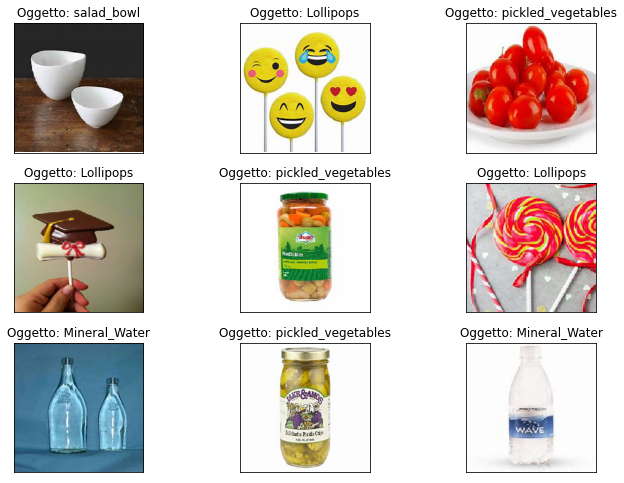

In [8]:
stampa(x_train, y_train, class_names)

In [9]:
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [10]:
# exclude the last 5 layers of the model so we include everything up 
# to the the last global_average_pooling layer
x = mobile.layers[-6].output

In [11]:
output = Dense(units=8, activation='softmax')(x)

In [12]:
model = tf.keras.models.Model(inputs=mobile.input, outputs=output)

#we train only the last 30 layers of mobile net
for layer in model.layers[:-30]:
    layer.trainable = False

In [13]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(x_train, y_train, batch_size=100, epochs = 10,
                   validation_data=(x_val, y_val))

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
156/156 [==============================] - ETA: 0s - loss: 0.4283 - accuracy: 0.8667WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001F4BDF95828> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and atta

In [15]:
def plot_metrics(history):
  # plotting the metrics
  fig = plt.figure()
  plt.subplot(2,1,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='lower right')

  plt.subplot(2,1,2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

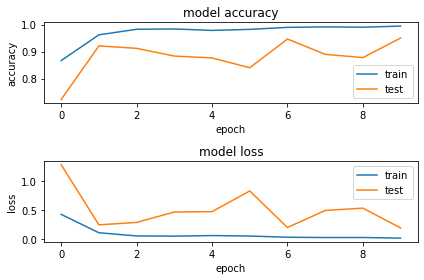

In [16]:
plot_metrics(history)

In [17]:
loss_and_metrics = model.evaluate(x_test, y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

44/44 - 4s - loss: 0.1388 - accuracy: 0.9596
Test Loss 0.1387966424226761
Test Accuracy 0.9595959782600403


In [18]:
predicted_classes_crossentropy = np.argmax(model.predict(x_test), axis=-1)

# see which we predicted correctly and which not
correct_indices_crossentropy = np.nonzero(predicted_classes_crossentropy == test_labels)[0]
incorrect_indices_crossentropy = np.nonzero(predicted_classes_crossentropy != test_labels)[0]
print()
print(len(correct_indices_crossentropy)," classified correctly")
print(len(incorrect_indices_crossentropy)," classified incorrectly")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

1330  classified correctly
56  classified incorrectly


In [19]:
t0= time.process_time()
y_pred_sm = model.predict(x_test)
t1 = time.process_time() - t0
print("Time elapsed: ", t1, " seconds")

y_pred = np.argmax(y_pred_sm, axis=1)

Time elapsed:  5.5625  seconds


In [20]:
print(classification_report(test_labels, y_pred, labels=None))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       155
           1       0.97      0.98      0.98       187
           2       0.91      0.99      0.95       168
           3       0.99      0.98      0.98       163
           4       0.99      0.92      0.95       180
           5       0.99      0.90      0.94       180
           6       0.93      0.97      0.95       183
           7       1.00      0.98      0.99       170

    accuracy                           0.96      1386
   macro avg       0.96      0.96      0.96      1386
weighted avg       0.96      0.96      0.96      1386



In [21]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

[[149   0   1   1   0   2   2   0]
 [  0 184   1   0   2   0   0   0]
 [  2   0 166   0   0   0   0   0]
 [  2   0   2 159   0   0   0   0]
 [  2   4   3   0 165   0   6   0]
 [  7   0   7   0   0 162   4   0]
 [  2   1   2   0   0   0 178   0]
 [  0   1   0   0   0   0   2 167]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

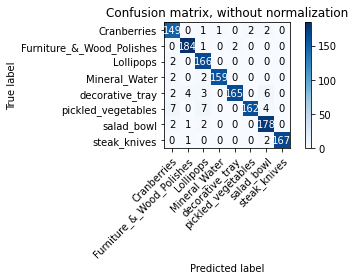

In [23]:
cm = confusion_matrix(test_labels, y_pred, labels=None, sample_weight=None)
print(cm)
plot_confusion_matrix(test_labels, y_pred, classes=class_names, normalize=False)